# PPO for Mujoco, with additional implementation details

We'll implement selected implementation details from [The 37 Implementation Details of Proximal Policy Optimization](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/) that I was missing only based on the paper / referenced literature:

**13 core implementation details**

* 2. a) Orthogonal Initialization of Weights
* 2. a) Constant Initialization of biases (=0)
* 2. b) Policy output layer weights are initialized with the scale of 0.01
* 3. The Adam Optimizer’s Epsilon Parameter
* 4. Adam Learning Rate Annealing. In MuJoCo, the learning rate linearly decays from 3e-4 to 0.
* 7. Normalization of Advantages
* 9. Value Function Loss Clipping
* 11. Global Gradient Clipping


**9 details for continuous action domains (e.g. Mujoco)**

* 6. Normalization of Observation, 7. Observation Clipping
* 8. Reward Scaling, 9. Reward Clipping

Additionally, I won't be using TruncatedNormal anymore, but rather Normal + ActionClipping.
* 5. Handling of action clipping to valid range and storage

Additionally, I misinterpreted how mini-batches are handled. I thought the 2048 time steps are split in mini-batches of 64 time-steps, of which 10 are sampled and used for 10 updates (10 epochs). Instead, the 2024 time-steps are broken up in chunks of 64 time-steps, which are all used for a gradient step, and this is repeated 10 times. This effectively increases the number of gradient steps from 10 to 10*(2024/64) = 320 per sampled set of 2024 time-steps.

This, and the reward scaling have had the largest impacts on performance, together with many, many bugs.

In [1]:
import gymnasium as gym
# 5. Handling of action clipping to valid range and storage
from gymnasium.wrappers import RescaleAction, ClipAction

import numpy as np

import torch
from torch import nn

# from torchrl.modules import TruncatedNormal # continuous bounded action space
# 5. Handling of action clipping to valid range and storage
from torch.distributions import Normal

import random # sample losses

import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import LinearLR

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '../utils')))
from ppoutils import (OnlineStats,           # used in custom scaling of observations
                      NormalizeRewardCustom) # modification of gymnasium.wrappers.NormalizeReward to store the unmodified reward

In [2]:
# The policy needs to be modified to return a mean tensor and a standard deviations tensor
# - use logits as mean
# - standard deviations separate
# - no dependencies between dimensions of multi-variate normal distribution
class Policy(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, n_out),
        )

        for name, param in self.net.named_parameters():
            # 2. a) Constant Initialization of biases (=0)
            if 'bias' in name:
                nn.init.zeros_(param)
            # 2. a) Orthogonal Initialization of Weights
            if 'weight' in name:
                torch.nn.init.orthogonal_(param, np.sqrt(2))
                

        # 2. b) Policy output layer weights are initialized with the scale of 0.01
        nn.init.orthogonal_(self.net[-1].weight, 0.01)

        
        # From PPO, page 6: 
        # "To represent the policy, we used a fully-connected MLP with two hidden layers of 64 units,
        # and tanh nonlinearities, outputting the mean of a Gaussian distribution, with variable standard
        # deviations, following [Sch+15b; Dua+16]."
        # (See [Sch+15b] (Trust Region Policy Optimization) on page 15.)
        # Initialization of the standard deviations is not fully clear here, 
        # but to initialize them to 1 seems a reasonable first guess.
        self.log_stddevs = nn.Parameter(torch.zeros(n_out))

        # 6. Normalization of Observation, 7. Observation Clipping
        self.running_stats = OnlineStats()
    
    def forward(self, x):
        # 6. Normalization of Observation, 7. Observation Clipping
        if self.training:
            self.running_stats.update(x)
        x = torch.clamp((x - self.running_stats.mean) / (self.running_stats.std + 1e-8), -10, 10)

        logits = self.net(x)
        stddevs = torch.exp(self.log_stddevs)
        return logits, stddevs
    
class Value(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, 1), # same as Policy, but output is only one number
        )

        for name, param in self.net.named_parameters():
            # 2. a) Constant Initialization of biases (=0)
            if 'bias' in name:
                nn.init.zeros_(param)
            # 2. a) Orthogonal Initialization of Weights
            if 'weight' in name:
                torch.nn.init.orthogonal_(param, np.sqrt(2))
        
        nn.init.orthogonal_(self.net[-1].weight, 1.0)
        
        # 6. Normalization of Observation, 7. Observation Clipping
        self.running_stats = OnlineStats()
    
    def forward(self, x): 
        # 6. Normalization of Observation, 7. Observation Clipping
        if self.training:
            self.running_stats.update(x)
        x = torch.clamp((x - self.running_stats.mean) / (self.running_stats.std + 1e-8), -10, 10)

        logit = self.net(x)
        return logit

In [3]:
# Possible environments
envs = [
    # Continuous environments in Gymnasium:
    # "Pendulum-v1",
    # "MountainCarContinuous-v0",
    # "BipedalWalker-v3",
    # "LunarLander-v3",
    # "CarRacing-v3", # image input
    
    # Mujoco environments used by PPO (with updated version numbers):
    "HalfCheetah-v5",
    "Hopper-v5",
    "InvertedDoublePendulum-v5",
    "InvertedPendulum-v5",
    "Reacher-v5",
    "Swimmer-v5",
    "Walker2d-v5"
]

for env_name in envs:
    env = gym.make(env_name, continuous=True) if env_name in ["LunarLander-v3", "CarRacing-v3"] else gym.make(env_name)
    print(f"{env_name:25}: {env.action_space}")

HalfCheetah-v5           : Box(-1.0, 1.0, (6,), float32)
Hopper-v5                : Box(-1.0, 1.0, (3,), float32)
InvertedDoublePendulum-v5: Box(-1.0, 1.0, (1,), float32)
InvertedPendulum-v5      : Box(-3.0, 3.0, (1,), float32)
Reacher-v5               : Box(-1.0, 1.0, (2,), float32)
Swimmer-v5               : Box(-1.0, 1.0, (2,), float32)
Walker2d-v5              : Box(-1.0, 1.0, (6,), float32)


In [7]:
seed = 42
env_name = "Swimmer-v5"

n_hidden1 = 64 
n_hidden2 = 64

gamma = 0.9999 # Should be 0.99, changed to test Swimmer
gae_lambda = 0.95 # New parameter for generalized advantage estimation

eps = 0.2 # New clipping parameter

# Sutton & Barto use a separate learning rate to update the state-value function parameters
# PPO has the same learning rate for both policy and value function
alpha = 3e-4

n_steps = 1_000_000 # should be 1_000_000
T = 2048 # should be 2048
n_epochs = 10 # should be 10
minibatch_size = 64 # should be 64

print_every_n_episodes = 10

In [8]:
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make(env_name, continuous=True) if env_name in ["LunarLander-v3", "CarRacing-v3"] else gym.make(env_name)
env = RescaleAction(env, min_action=-1, max_action=1)
# 5. Handling of action clipping to valid range and storage
env = ClipAction(env)

# 8. Reward Scaling, 9. Reward Clipping
env = NormalizeRewardCustom(env)
# clip reward is inline below

# Reset the environment to generate the first observation
observation, info = env.reset(seed=seed)
observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)

policy = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=env.action_space.shape[0])

# The state-value function maps states to a single number. From PPO: "We don’t share parameters between the policy and value function [...]". 
value = Value(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2)


# Sutton & Barto use separate gradient update steps with separate learning rates for the policy and the state-value function
# PPO has the same learning rate for both policy and value function
# 3. The Adam Optimizer’s Epsilon Parameter
optimizer = torch.optim.Adam(list(policy.parameters()) + list(value.parameters()), lr=alpha, maximize=True, eps=1e-5)

# 4. Adam Learning Rate Annealing. In MuJoCo, the learning rate linearly decays from 3e-4 to 0.
n_gradient_steps = int(np.ceil(n_steps / T)) # This corresponds to stepping the scheduler once per sampled batch of data
scheduler = LinearLR(optimizer, start_factor=1, end_factor=0, total_iters=n_gradient_steps)


all_episode_rewards = []


i_global_timestep = 1
while i_global_timestep <= n_steps:

    # track information for roll-outs in the form of nested lists, where the total number of elements is T, 
    # and the inner lists are episodes
    rewards_horizon = []
    observations_horizon = []
    actions_horizon = []
    log_probs_horizon = []
    values_horizon = [] # also track the value function
    
    # informaton per episode, in the form (s_t, a_t) -> (r_t, s_{t+1})
    rewards_episode = [] # T rewards from 1 to T
    original_rewards_episode = []
    observations_episode = [observation] # T observations from 0 to T-1, the policy expects tensors as input
    actions_episode = [] # T actions from 0 to T-1
    log_probs_episode = []
    values_episode = [value(observation)] # same as observations, but if episode ends one 0 will be appended

    # roll-out of episode(s) following the policy, for T total time-steps
    done = False
    i_horizon_timestep = 0
    while i_horizon_timestep < T:
        
        # probabilities for actions
        # The policy network outputs means and standard deviations
        pred_means, pred_stddevs = policy(observation)
        
        # sample an action according to the probabilities
        # We use the truncated normal distribution on the continuous action space, not the categorical distribution for a discrete set of actions
        # TN = TruncatedNormal(loc=pred_means,
        #                     scale=pred_stddevs,
        #                     low=env.action_space.low,
        #                     high=env.action_space.high,
        #                     tanh_loc=False)
        # 5. Handling of action clipping to valid range and storage
        N = Normal(loc=pred_means, scale=pred_stddevs)
        # action = TN.sample()
        action = N.sample()

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        # 8. Reward Scaling, 9. Reward Clipping ("reward" is now a normalized reward)
        observation, reward, terminated, truncated, info = env.step(action.detach().numpy())

        # To save reward over time, get back the un-normalized reward
        original_reward = env.original_reward
        reward = np.clip(reward, -10, 10)

        i_horizon_timestep += 1
        observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)
        done = terminated or truncated

        # build up one episode
        rewards_episode.append(reward)
        original_rewards_episode.append(original_reward)
        observations_episode.append(observation) # TODO this is saving the next state even if the environment is done
        actions_episode.append(action)
        # log_probs_episode.append(TN.log_prob(action).sum().detach())
        log_probs_episode.append(N.log_prob(action).sum().detach())
        values_episode.append(value(observation)) # this is the observation after taking action

        # If the episode or the time-steps have ended then we can reset to start a new episode
        if done or i_horizon_timestep == T:
            observation, info = env.reset()
            observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)
            
            # track quantities per episode
            rewards_horizon.append(rewards_episode)
            observations_horizon.append(observations_episode)
            actions_horizon.append(actions_episode)
            log_probs_horizon.append(log_probs_episode)
            if done:
                values_episode[-1] = torch.zeros_like(values_episode[-1]) # value for next observation after termination should be 0
                all_episode_rewards.append(sum(original_rewards_episode)) # track total reward for all episodes

                # print some statistics after every n-th completed episode
                if len(all_episode_rewards) % print_every_n_episodes == 0: # TODO episode lengths may increase during training, print every x steps of the outer loop, not every x episodes
                    print("\nStep:", i_global_timestep, "of", n_steps)
                    print("Alpha:", alpha, "Gamma:", gamma, "Lambda:", gae_lambda)
                    print("Episodes completed:", len(all_episode_rewards))

                    print("LR:", scheduler.get_last_lr()[0])

                    if len(all_episode_rewards) >= 100: print("Average reward last 100 episodes:", np.mean(all_episode_rewards[-100:]))

            values_horizon.append(values_episode)
            # and reset them for the next episode roll-out
            rewards_episode = [] # T rewards from 1 to T
            original_rewards_episode = []
            observations_episode = [observation] # T observations from 0 to T-1, the policy expects tensors as input
            actions_episode = []
            log_probs_episode = []
            values_episode = [value(observation)]

            done = False # start new episode
    

    # The overall data collection will end at the next multiple of T after n_steps
    i_global_timestep += i_horizon_timestep 

    # We will evaluate value and policy at a previously seen observation, which we do not want to include again in the observation scaling.
    # So we need to add policy.training = False, and value.training = False.
    # But We'll include it before every call to value or policy, as including training=False here before the training loop is misleading

    for i_epoch in range(n_epochs):
        # Pick the indices of the time-steps to be used to update the policy
        # Having the sampling outside the epoch loop corresponds to sampling without replacement (every time-step is used at most once)
        # Moving this inside the epoch loop will make it sampling with replacement (time-steps can be used more than once)
        loss_indices = list(range(T))
        random.shuffle(loss_indices)
        
        for i_minibatch in range(int(T/minibatch_size)):
            # get time-steps that will be used in this mini-batch
            # custom version of sampling without replacement, but in a way that allows additional epochs even when all elements have already been sampled
            mini_batch_indices = loss_indices[:minibatch_size]
            del loss_indices[:minibatch_size] # "popleft"
            loss_indices.extend(mini_batch_indices) # and then insert back in


            # Calculate loss
            # We accumulate gradients over one mini-batch and make one gradient step per mini-batch
            pseudo_losses = []
            rs, Ats, vs, volds = [], [], [], []
            # We now unpack the nested list structure that stores the episode roll-outs
            rollouts_step_counter = -1 # we use this to filter out our mini-batch
            for i_ep, rewards_episode in enumerate(rewards_horizon):
                observations_episode = observations_horizon[i_ep]
                actions_episode = actions_horizon[i_ep]
                log_probs_episode = log_probs_horizon[i_ep]
                values_episode = values_horizon[i_ep]
                for t in range(len(rewards_episode)):
                    rollouts_step_counter +=1 # We need to maintain the episode structure to calculate advantages as they access information in order until the end of the episode roll-out
                    if rollouts_step_counter in mini_batch_indices: # this filters for mini-batch
                    
                        observation = observations_episode[t]
                        action = actions_episode[t]
                        log_prob_old = log_probs_episode[t]
                        value_old = values_episode[t].detach() # TODO detach() shouldn't be necessary if everything in the buffer is without grad

                        rewards_ge_t = rewards_episode[t:T]
                        values_ge_t = values_episode[t:T+1][:-1]
                        values_ge_tp1 = values_episode[t:T+1][1:]
                        
                        deltas_ge_t = [r + gamma*vnext - v for r,vnext,v in zip(rewards_ge_t, values_ge_tp1, values_ge_t)]

                        # Now we use all time-steps for training 10 times, so advantages are needed for each time-step. TODO move out of loop
                        Advantage_t = sum((gamma * gae_lambda)**i * d for i, d in enumerate(deltas_ge_t)) # TODO currently, advantages are fixed per roll-out, move up. TBD whether they should be updated as the value function gets updated

                        Advantage_t = Advantage_t.detach() # TODO detach() shouldn't be necessary if everything in the buffer is without grad

                        # log probs for old action at this observation but with updated policy
                        policy.training = False
                        pred_means, pred_stddevs = policy(observation)
                        policy.training = True
                        # TN = TruncatedNormal(loc=pred_means,
                        #                     scale=pred_stddevs,
                        #                     low=env.action_space.low,
                        #                     high=env.action_space.high,
                        #                     tanh_loc=False)
                        N = Normal(loc=pred_means, scale=pred_stddevs)

                        # log_prob = TN.log_prob(action).sum()
                        log_prob = N.log_prob(action).sum()


                        # ratio
                        r_t = torch.exp(log_prob - log_prob_old) # exp(log a - log b) = exp(log a) / exp(log b) = a / b
                        rs.append(r_t)

                        # Clipped objective
                        # L_clip = torch.min(r_t*Advantage_t, torch.clamp(r_t, 1-eps, 1+eps)*Advantage_t)
                        Ats.append(Advantage_t)

                        # Value loss, now in form of MSE loss, using: Advantage = -V + V_targ => V - V_targ = V - (A + V_old)
                        # L_value = 0.5 * (value(observation) - Advantage_t - value_old)**2
                        value.training = False
                        vs.append(value(observation))
                        value.training = True
                        volds.append(value_old)

                        # pseudo_losses.append(L_clip - L_value) # collect the losses for each sampled time-step in this mini-batch
            

            # 7. Normalization of Advantages
            m, s = torch.cat(Ats).mean(), torch.cat(Ats).std()
            Ats_normalized = [(a - m) / (s + 1e-8) for a in Ats]

            for r, A, v, vold in zip(rs, Ats_normalized, vs, volds):
                L_clip = torch.min(r*A, torch.clamp(r, 1-eps, 1+eps)*A)
                
                # 9. Value Function Loss Clipping
                # L_value = 0.5 * (v - A - vold)**2
                # two variants of loss (unclipped, clipped), want to minimize, but not too far -> use larger of both quantities
                L_value = 0.5 * torch.max( (v - A - vold)**2, (torch.clamp(v, vold - eps, vold+eps) - A - vold)**2 ) 

                pseudo_losses.append(L_clip - L_value)

            pseudo_loss = torch.stack(pseudo_losses).mean()
            
            # Now one gradient step for the combined policy and value function loss
            optimizer.zero_grad()
            pseudo_loss.backward()

            # 11. Global Gradient Clipping
            nn.utils.clip_grad_norm_(list(policy.parameters()) + list(value.parameters()), 0.5)
            
            optimizer.step()
        
    # 4. Adam Learning Rate Annealing. In MuJoCo, the learning rate linearly decays from 3e-4 to 0.
    scheduler.step()
    


env.close()


Step: 8193 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 10
LR: 0.00029754601226993863

Step: 18433 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 20
LR: 0.0002944785276073619

Step: 28673 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 30
LR: 0.0002914110429447853

Step: 38913 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 40
LR: 0.0002883435582822087

Step: 49153 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 50
LR: 0.000285276073619632

Step: 59393 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 60
LR: 0.00028220858895705526

Step: 69633 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 70
LR: 0.00027914110429447866

Step: 79873 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 80
LR: 0.00027607361963190205

Step: 90113 of 1000000
Alpha: 0.0003 Gamma: 0.9999 Lambda: 0.95
Episodes completed: 9

KeyboardInterrupt: 

### Save and load trained policies

In [ ]:
import pickle

# Uncomment to save a trained policy:
# pickle.dump(policy, open('../policies/PPO_implementation_details_Swimmer-v5_gamma09999.pkl', 'wb'))

# Uncomment to load a saved policy:
# policy = pickle.load(open('../policies/PPO_Mujoco_impl_Swimmer-v5_1000000steps.pkl', 'rb'))

### Plotting training progress

Text(0.5, 1.0, 'Swimmer-v5\nReward threshold: 360.0')

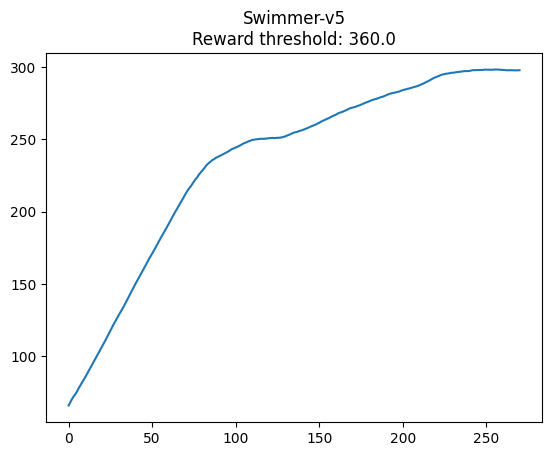

In [10]:
smoothing_interval = 100 # Change for different levels of smoothing
smoothed_rewards = np.convolve(all_episode_rewards, np.ones(smoothing_interval)/smoothing_interval, 'valid')
plt.plot(smoothed_rewards)
plt.title(f"{env_name}\nReward threshold: {env.spec.reward_threshold}")

## Visualize the policy


In [ ]:
# Initialise the environment
env = gym.make("Swimmer-v5", render_mode="human")
env = RescaleAction(env, min_action=-1, max_action=1)
env = ClipAction(env)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

policy.eval()

done = False
while not done:

    pred_means, pred_stddevs = policy(torch.tensor(observation, requires_grad=False, dtype=torch.float32))
    # action = pred_means # TODO: should sampling also be stochastic?
    
    N = Normal(loc=pred_means, scale=pred_stddevs)
    action = N.sample()
    
    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action.detach().numpy())
    
    # If the episode has ended then we can reset to start a new episode
    done = terminated or truncated
    if done:
        observation, info = env.reset()

env.close()

## Results

I ran the above code for the 7 environments used in the PPO paper (code with minor modifications not shown here) for 1 mio time-steps, and the results are as follows:

(Note the x-axis is episodes completed during sampling from the environment, except for the pendulums, where I changed to approximate time-steps).

![](../assets/Comparison_PPO_correctbatches_PPO_all_details.png)

Results are qualitatively roughly in line with the PPO paper, except for Hopper-v5 and Swimmer-v5. 

Swimmer gets much higher reward with a higher discount factor (250+ total reward with $\gamma = 0.9999$).

I don't know yet what causes the poor performance for Hopper.



Results from PPO paper for comparison:
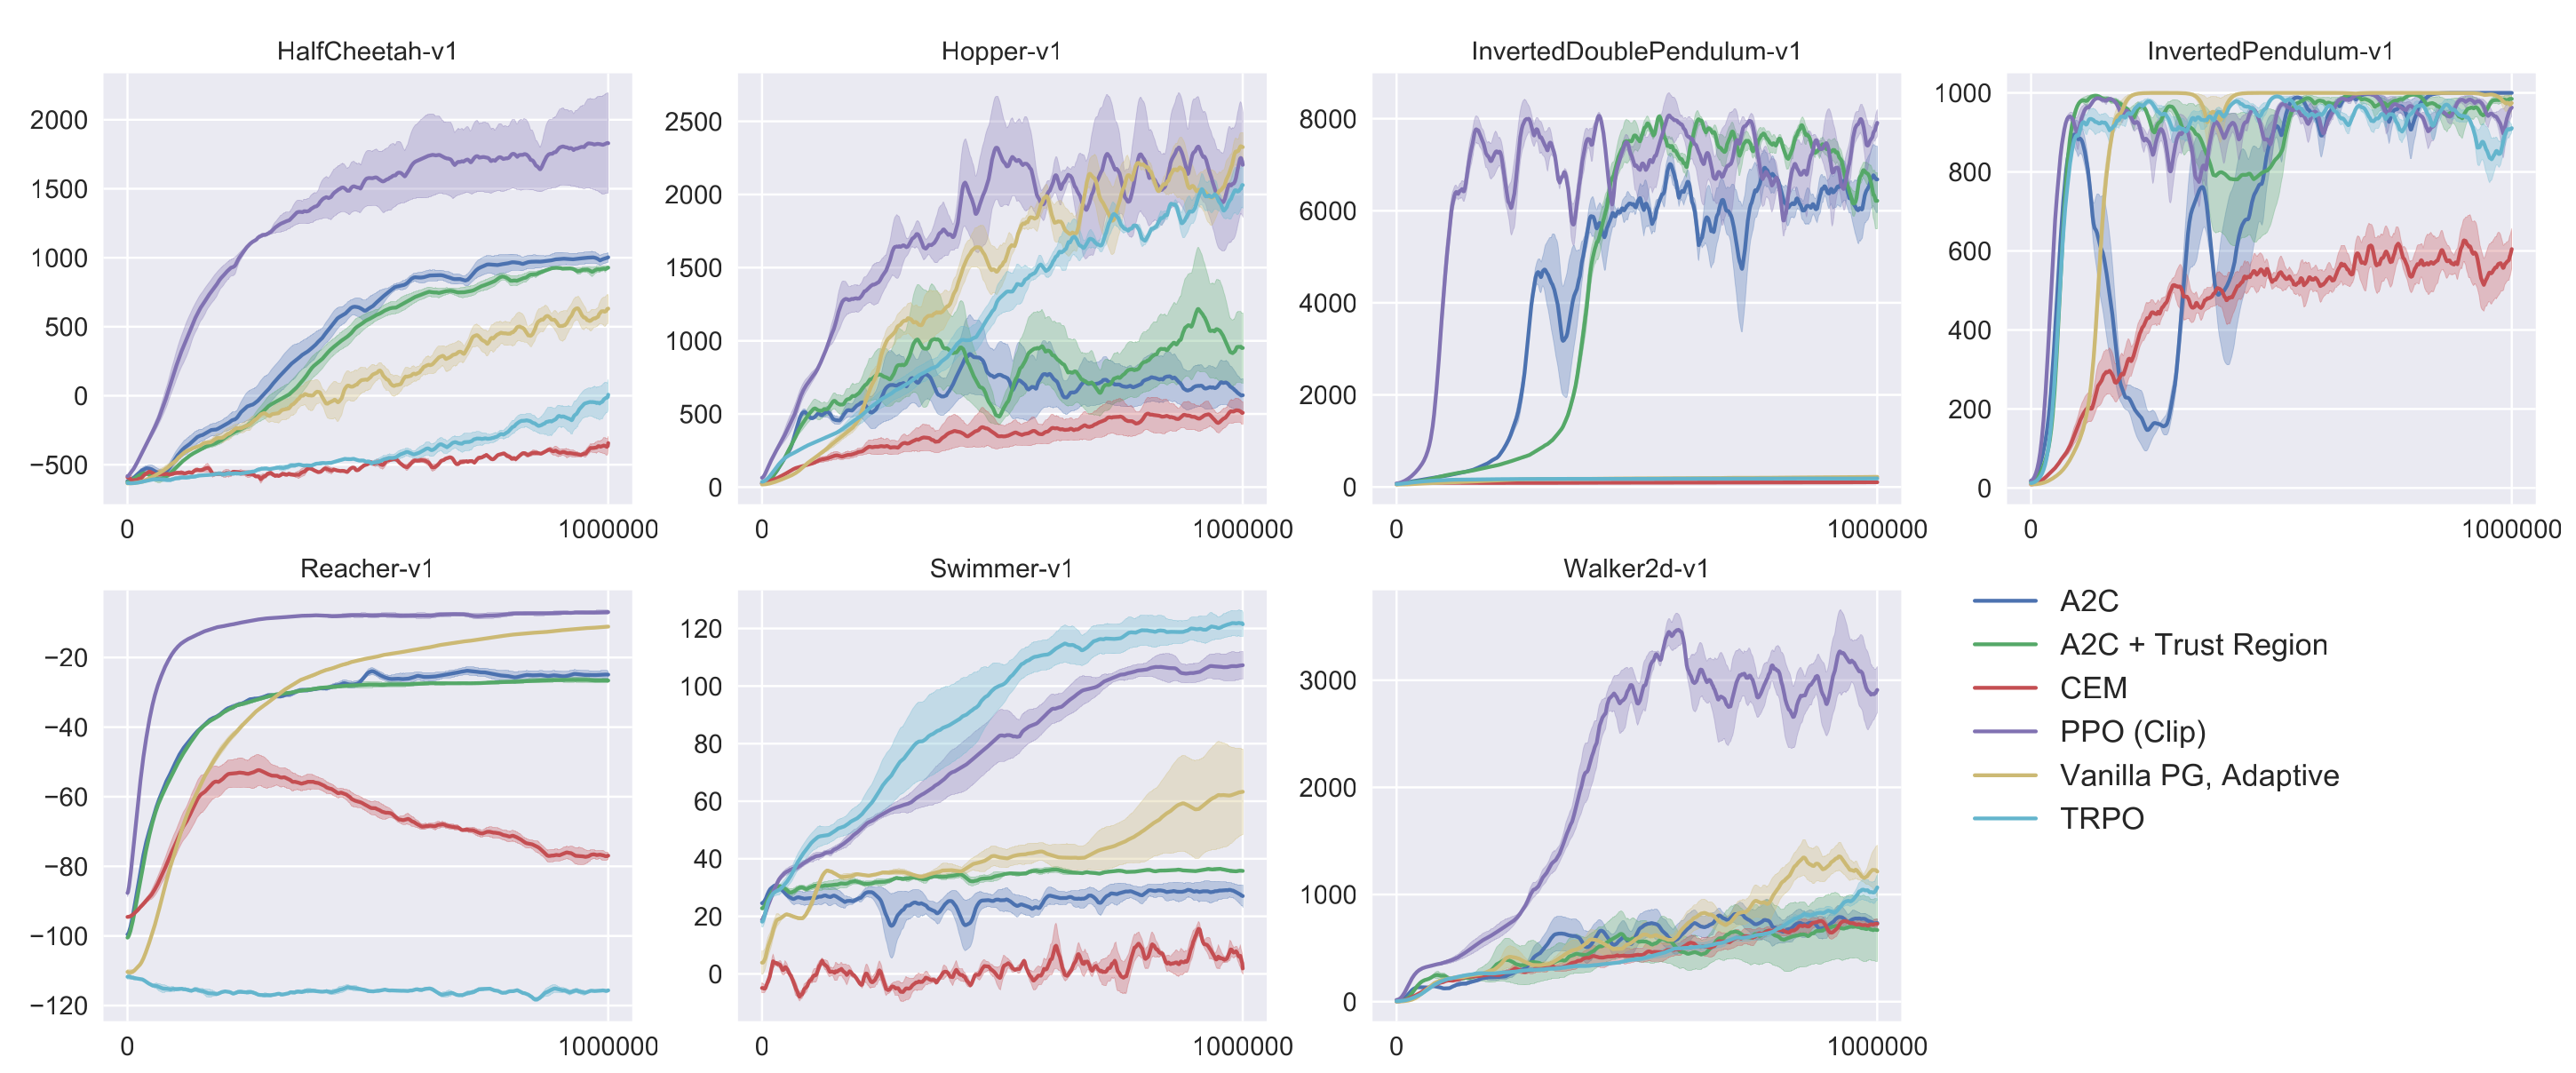